In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from yeastnet import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [2]:
# Model 3: mRNA and protein, separate inhibition and activation, linear activation.
def f3(y, t0, u, k_tf, kf, k_prot, Aa, Ai):
    '''
    u: N-vector of initial activation strength.
    k_tf: N-vector of TF strengths.
    kf: N-vector of feedbacks for each gene.
    k_prot: Protein constant.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = Aa - Ai
    #print(A.shape)
    A = (k_tf * A.transpose()).transpose()
    
    dm = A @ p - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

def error_prot_model(params, y_data, N, hss_indices, Aa, Ai, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    k_prot = params[-1]
    
    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, k_tf, kf, k_prot, Aa, Ai))
    m = y[:,:N]
    
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

def get_predictions_f3(params, hss_indices, Aa, Ai, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=5):
    N = Aa.shape[0]
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    #print('u0', len(u0))
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    #print('kf', len(kf), kf)
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    #print('k_tf', len(k_tf))
    k_prot = params[-1]
    #print(k_prot)

    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=times,
               args=(u, k_tf, kf, k_prot, Aa, Ai),)
    return y[:,:N]

In [3]:
def combine_networks(act, inh):
    Aa = nx.adjacency_matrix(act).toarray()
    Ai = nx.adjacency_matrix(inh).toarray()
    W = Aa - Ai
    
    mixed_network = nx.DiGraph(data=np.array(W))
    names = act.nodes()
    mixed_network = nx.relabel_nodes(mixed_network, {i:name for i, name in enumerate(names)})
    return mixed_network

def shortest_path_length(network, s, node):
    try:
        return nx.shortest_path_length(network, s, node)
    except:
        return np.inf

def shortest_path_to_hss(network, node, starters):
    #print(node)
    path_lengths = [shortest_path_length(network, s, node) for s in starters]
    return min(path_lengths)

In [4]:
# Read full network data.
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")

# Transform into matrices (as np.array).
Aa = squarify(yeastract_data_activation)
Ai = squarify(yeastract_data_inhibition)

# Read timecourse data.
cols = list(Aa.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)

# Reorder matrices to have same order than timecourse data.
Aa = reorder(list(gasch_data.index), Aa)
Ai = reorder(list(gasch_data.index), Ai)

names = list(Aa)

Aa, Ai = np.array(Aa), np.array(Ai)

# Remove diagonal elements.
np.fill_diagonal(Aa, 0) 
np.fill_diagonal(Ai, 0)

# Turn into networkx objects.
network_act = nx.DiGraph(data=np.array(Aa))
network_inh = nx.DiGraph(data=np.array(Ai))


network_act = nx.relabel_nodes(network_act, {i:name for i, name in enumerate(names)})
network_inh = nx.relabel_nodes(network_inh, {i:name for i, name in enumerate(names)})

W = Aa - Ai
mixed_network = nx.DiGraph(data=np.array(W))
mixed_network = nx.relabel_nodes(mixed_network, {i:name for i, name in enumerate(names)})

In [5]:
def hss_successors(mixed_network, starters, only_tf=True):
    nodelist = []
    for node in mixed_network.nodes():
        # Check if there exists a path from any of the HSS to current node.
        if np.any([nx.has_path(mixed_network, st, node) for st in starters]):
            if not only_tf:
                nodelist.append(node)
            elif mixed_network.out_degree(node) != 0:
                nodelist.append(node)
    return nodelist

heat_shock_starters = ["HSF1", "MSN2", "MSN4", "RLM1", "SWI4"]

# Get TF successor subnetwork.
subnet_nodelist = hss_successors(mixed_network, heat_shock_starters, only_tf=True)
sn_act, sn_inh = network_act.subgraph(subnet_nodelist), network_inh.subgraph(subnet_nodelist)
sn = combine_networks(sn_act, sn_inh)
nodes = np.array(sn.nodes())

In [6]:
# Create first neighbor subnetworks.
path_lengths = np.array([shortest_path_to_hss(sn, node, heat_shock_starters) for node in sn.nodes()])

nodes1 = list(nodes[path_lengths <= 1])
sn1_act, sn1_inh = sn_act.subgraph(nodes1), sn_inh.subgraph(nodes1)

A1a, A1i = nx.adjacency_matrix(sn1_act), nx.adjacency_matrix(sn1_inh)
A1a, A1i = A1a.toarray().transpose(), A1i.toarray().transpose()

N = len(nodes1)
hss_indices = [nodes1.index(tf) for tf in heat_shock_starters]

I stored the model parameters from our fit with a library called pickle, that lets you save arbitrary Python objects.
I now load them and plot the results.

In [7]:
import pickle
fit_params = pickle.load(open('fit_params_subnetwork.p', 'rb'))

times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

# You can change this if you want higher resolution for the model timepoints. 
# I kind of find it better to just look at the same timepoints to more easily
# compare with data in this plot.
ts = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5)

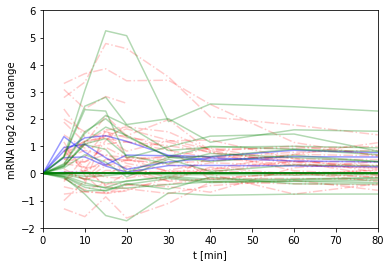

In [8]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-.', color="red", alpha=0.2)
plt.plot(ts, y_pred[:, hss_indices], '-', color="blue", alpha=0.4)
plt.plot(ts, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '-', color='green', alpha=0.3)
plt.xlabel('t [min]')
plt.ylabel('mRNA log2 fold change')
plt.xlim(0, 80)
plt.ylim(-2, 6)
plt.show()

In [9]:
?plt.legend

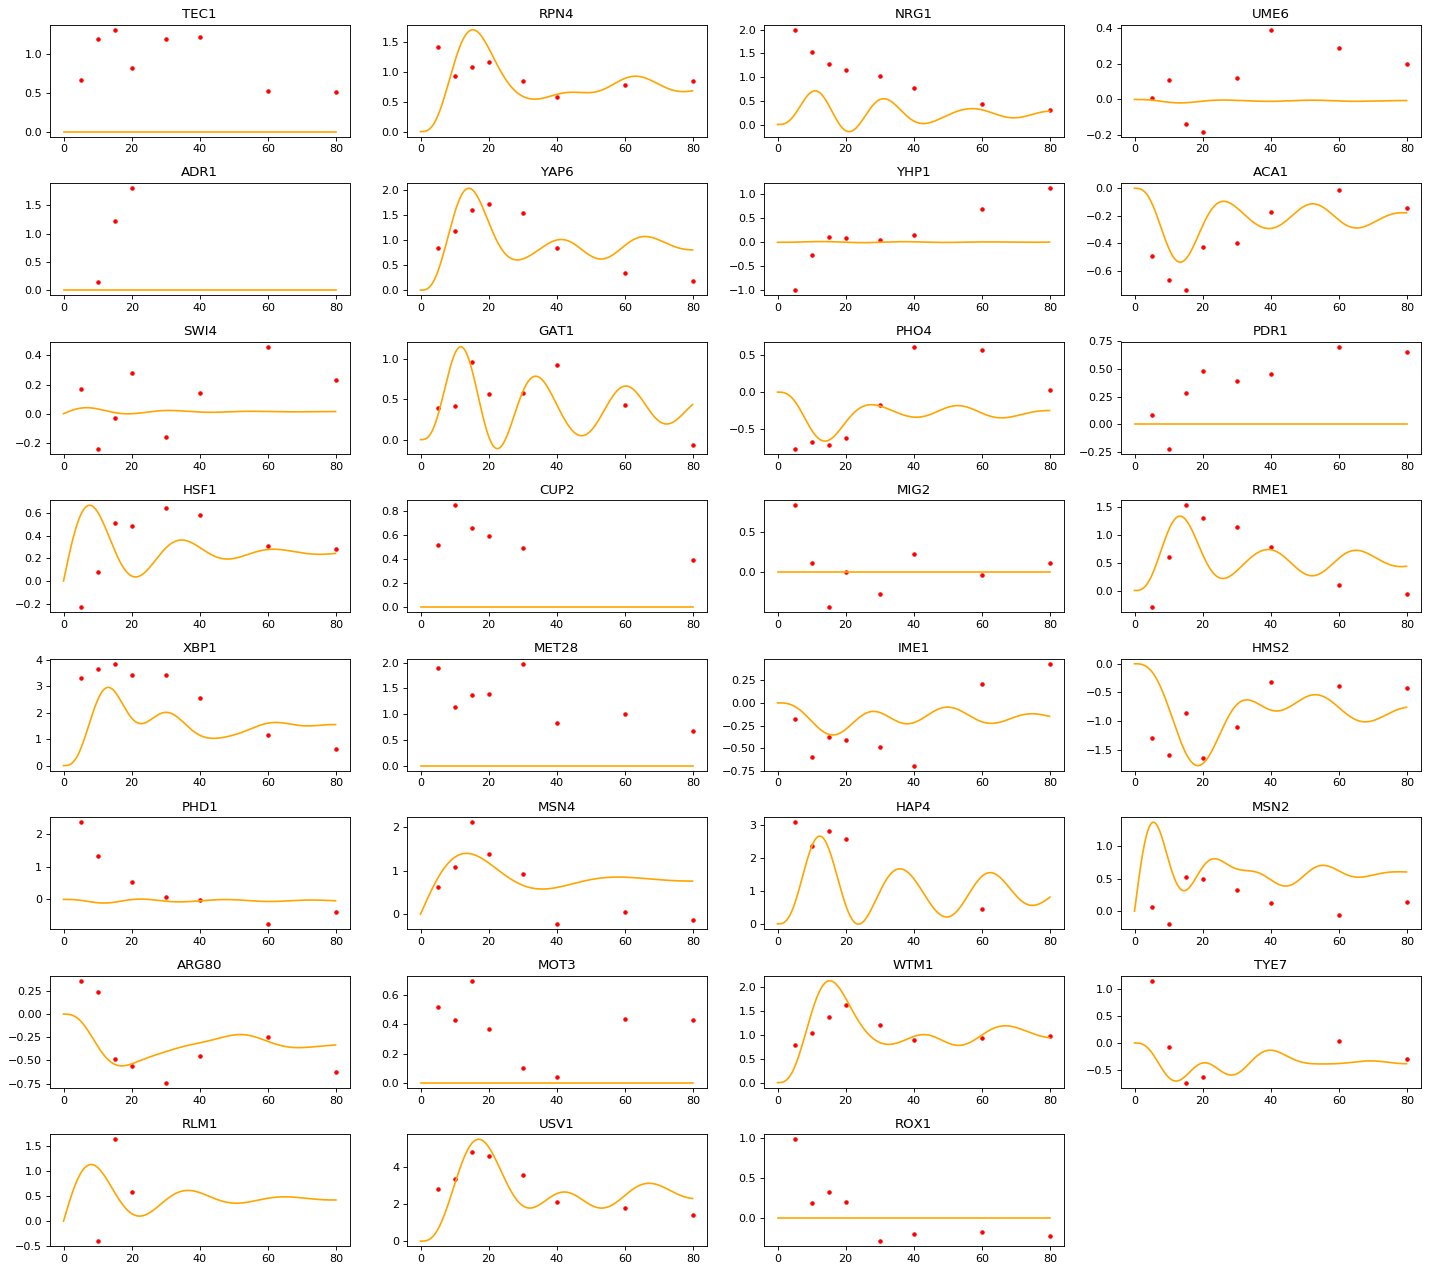

In [10]:
# Change time to sample from model to have higher resolution.
ts = np.arange(0, 80, 0.1)
y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5)
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]

plt.figure(figsize=(18, 16), dpi=80)
for i, node in enumerate(nodes1):
    plt.subplot(8, 4, i + 1)
    plt.plot(times[1:], y_data.iloc[i,:], '.', color="red")
    plt.plot(ts, y_pred[:, i], '-', color="orange")
    plt.title(node)
    #plt.plot(times, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '.-', color = 'red', alpha=0.3)
    #plt.xlim(0, 80)
    #plt.ylim(-2, 3)
plt.tight_layout()
plt.show()

In [11]:
in_degrees = [sn1_act.in_degree(node) + sn1_inh.in_degree(node) for node in sn1_act.nodes()]
out_degrees = [sn1_act.out_degree(node) + sn1_inh.out_degree(node) for node in sn1_act.nodes()]

y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=times[1:], n_hss=5)
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]

In [12]:
A1a.shape

(31, 31)

In [13]:
y_data.shape
y_pred.shape

(8, 31)

In [14]:
mad_errors = np.nanmean(np.abs(y_data.transpose() - y_pred), axis=0)

In [38]:
out_degrees = np.array(out_degrees)
transf_od = np.log2(out_degrees + 1)
mean_pred = np.mean(np.abs(y_pred), axis=0)

In [39]:
from scipy.stats import spearmanr
ind_spc = spearmanr(in_degrees, mad_errors/null_errors)
oud_spc = spearmanr(out_degrees, mad_errors/null_errors)
ind_spc_mp = spearmanr(in_degrees, mean_pred)
oud_spc_mp = spearmanr(out_degrees, mean_pred)

In [41]:
oud_spc_mp

SpearmanrResult(correlation=-0.088233674914197202, pvalue=0.63692780428516649)

In [28]:
spearmanr(out_degrees, mad_errors/null_errors)

SpearmanrResult(correlation=0.37344658718296753, pvalue=0.038512610004395383)

In [48]:
?plt.text

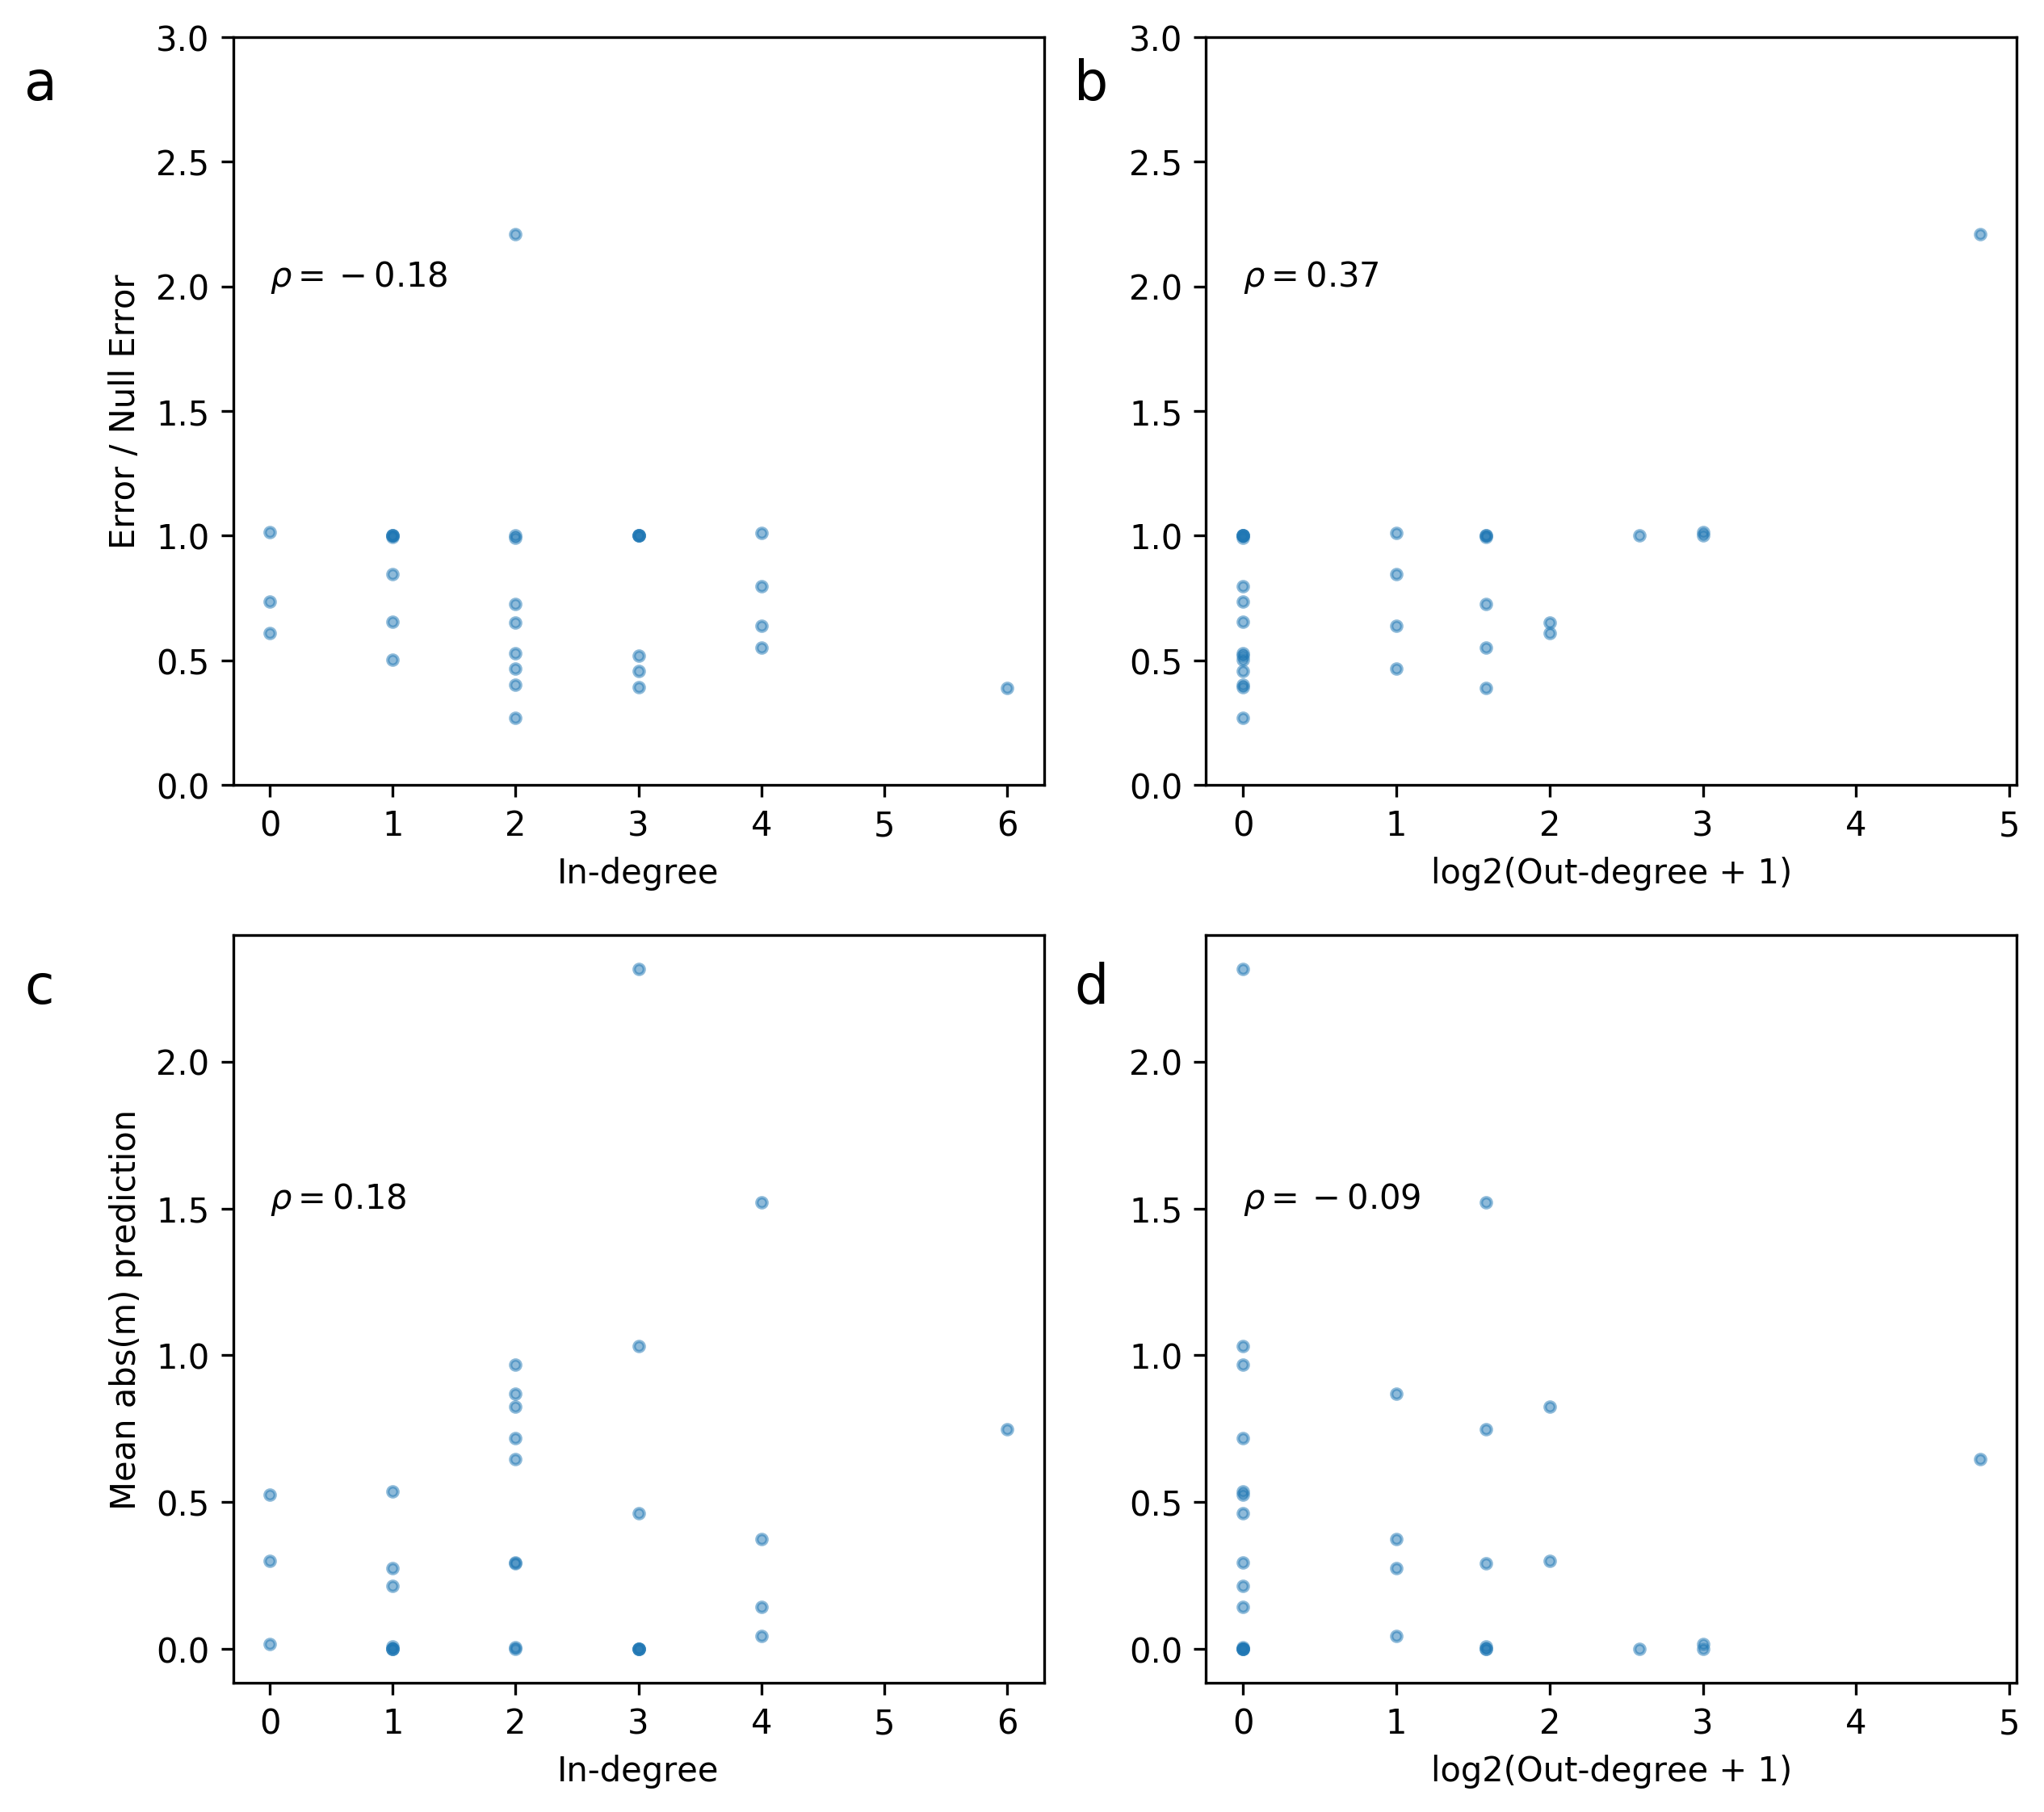

In [58]:
plt.figure(figsize=(9.5, 9), dpi=300)

plt.subplot(2, 2, 1)
plt.plot(in_degrees, mad_errors / null_errors, '.', alpha=0.5)
plt.xlabel("In-degree")
plt.ylabel("Error / Null Error")
plt.text(0, 2, r'$\rho = -0.18$')
plt.text(-2, 2.75, 'a', fontsize=16)
#plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(2, 2, 2)
plt.plot(transf_od, mad_errors / null_errors, '.', alpha=0.5)
plt.xlabel("log2(Out-degree + 1)")
plt.text(0, 2, r'$\rho = 0.37$')
plt.text(-1.1, 2.75, 'b', fontsize=16)
#plt.ylabel("Error (MAD) / Null error")
plt.ylim(0, 3)
#plt.title("Null model errors")

plt.subplot(2, 2, 3)
plt.plot(in_degrees, np.mean(np.abs(y_pred), axis=0), '.', alpha=0.5)
plt.xlabel("In-degree")
plt.text(0, 1.5, r'$\rho = 0.18$')
plt.text(-2, 2.2, 'c', fontsize=16)
plt.ylabel("Mean abs(m) prediction")
#plt.title("Mean abs prediction by in-degree")
#plt.xlim(0, 25)


plt.subplot(2, 2, 4)
plt.plot(transf_od, np.mean(np.abs(y_pred), axis=0), '.', alpha=0.5)
plt.xlabel("log2(Out-degree + 1)")
plt.text(0, 1.5, r'$\rho = -0.09$')
plt.text(-1.1, 2.2, 'd', fontsize=16)

#plt.ylabel("Mean abs(m) prediction")
#plt.title("Mean abs prediction by out-degree")
#plt.xlim(0, 25)


#plt.tight_layout()
plt.show()

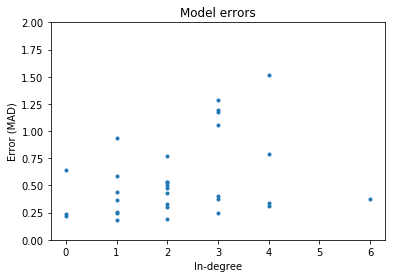

In [15]:
plt.plot(in_degrees, mad_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.title("Model errors")
plt.ylim(0, 2)
plt.show()

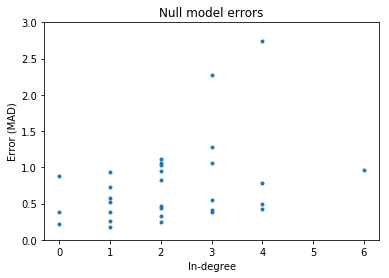

In [16]:
null_errors = np.nanmean(np.abs(y_data.transpose()), axis=0)
plt.plot(in_degrees, null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Null model errors")
plt.show()

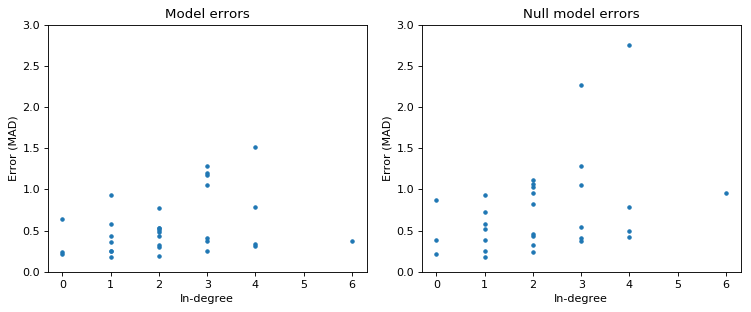

In [17]:
plt.figure(figsize=(9.5, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(in_degrees, mad_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(in_degrees, null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Null model errors")
plt.tight_layout()

plt.show()

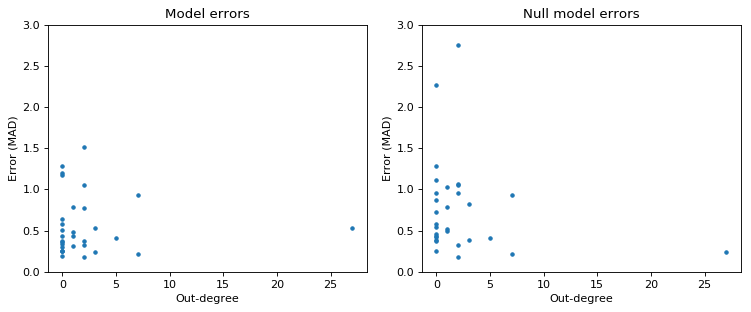

In [18]:
plt.figure(figsize=(9.5, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(out_degrees, mad_errors, '.')
plt.xlabel("Out-degree")
plt.ylabel("Error (MAD)")
plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(out_degrees, null_errors, '.')
plt.xlabel("Out-degree")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Null model errors")
plt.tight_layout()

plt.show()

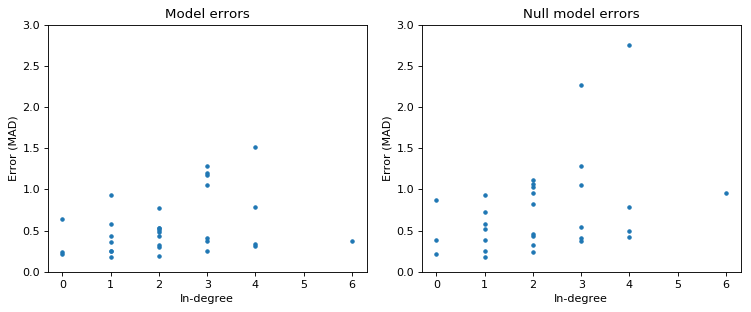

In [49]:
plt.figure(figsize=(9.5, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(in_degrees, mad_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(in_degrees, null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Null model errors")
plt.tight_layout()

plt.show()

In [89]:
plt.figure(figsize=(9.5, 9.5), dpi=300)
plt.subplot(2, 1, 1)
plt.plot(in_degrees, mad_errors / null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD) / Null error")
plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(2, 1, 2)
plt.plotnp.log2(np.array(out_degrees) + 1), mad_errors / null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD) / Null error")
plt.title("Model errors")
plt.ylim(0, 3)
plt.subplot(2, 2, 3)
plt.plot(in_degrees, null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Null model errors")
plt.tight_layout()

plt.show()

In [91]:
nodes1

['TEC1',
 'RPN4',
 'NRG1',
 'UME6',
 'ADR1',
 'YAP6',
 'YHP1',
 'ACA1',
 'SWI4',
 'GAT1',
 'PHO4',
 'PDR1',
 'HSF1',
 'CUP2',
 'MIG2',
 'RME1',
 'XBP1',
 'MET28',
 'IME1',
 'HMS2',
 'PHD1',
 'MSN4',
 'HAP4',
 'MSN2',
 'ARG80',
 'MOT3',
 'WTM1',
 'TYE7',
 'RLM1',
 'USV1',
 'ROX1']

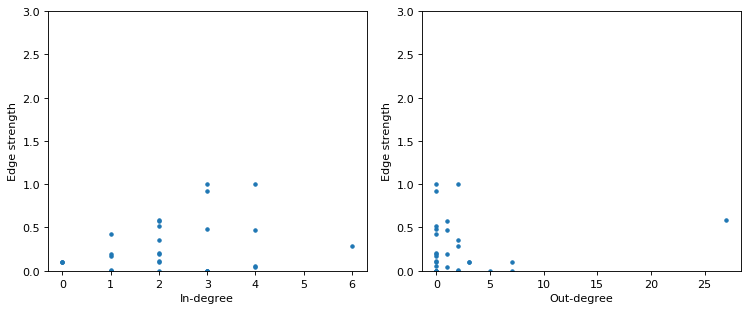

In [90]:
plt.figure(figsize=(9.5, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(in_degrees, k_tf, '.')
plt.xlabel("In-degree")
plt.ylabel("Edge strength")
#plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(out_degrees, k_tf, '.')
plt.xlabel("Out-degree")
plt.ylabel("Edge strength")
plt.ylim(0, 3)
#plt.title("Null model errors")
plt.tight_layout()

plt.show()

In [93]:
hss_indices

[12, 23, 21, 28, 8]

In [98]:
y_data.iloc[23, :]

Heat Shock 05 minutes hs-1    0.06
Heat Shock 10 minutes hs-1   -0.20
Heat Shock 15 minutes hs-1    0.52
Heat Shock 20 minutes hs-1    0.50
Heat Shock 30 minutes hs-1    0.32
Heat Shock 40 minutes hs-1    0.12
Heat Shock 60 minutes hs-1   -0.06
Heat Shock 80 minutes hs-1    0.14
Name: MSN2, dtype: float64

In [95]:
k_tf[hss_indices]

array([ 0.1       ,  0.59175394,  0.1       ,  0.1       ,  0.1       ])

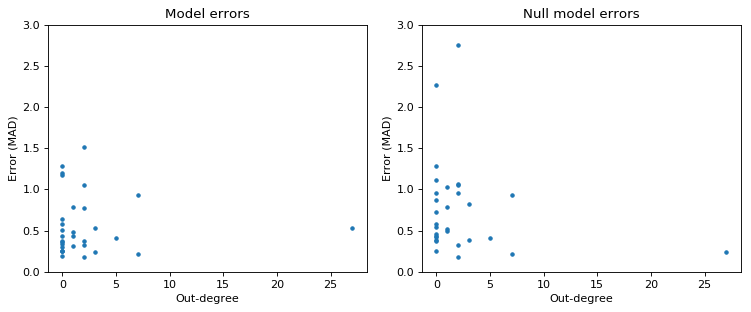

In [62]:
plt.figure(figsize=(9.5, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(out_degrees, mad_errors, '.')
plt.xlabel("Out-degree")
plt.ylabel("Error (MAD)")
plt.title("Model errors")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(out_degrees, null_errors, '.')
plt.xlabel("Out-degree")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Null model errors")
plt.tight_layout()
plt.show()

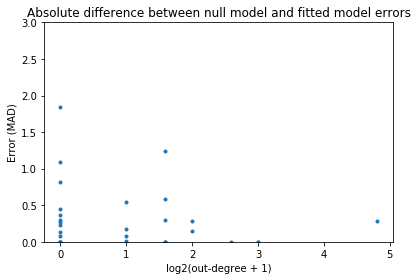

In [106]:
plt.plot(np.log2(np.array(out_degrees) + 1), np.abs(mad_errors - null_errors), '.')
plt.xlabel("log2(out-degree + 1)")
plt.ylabel("Error (MAD)")
plt.ylim(0, 3)
plt.title("Absolute difference between null model and fitted model errors")
plt.tight_layout()
plt.show()

In [104]:
?np.log

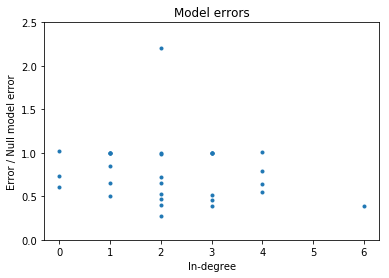

In [50]:
plt.plot(in_degrees, mad_errors / null_errors, '.')
plt.xlabel("In-degree")
plt.ylabel("Error / Null model error")
plt.title("Model errors")
plt.ylim(0, 2.5)
plt.show()

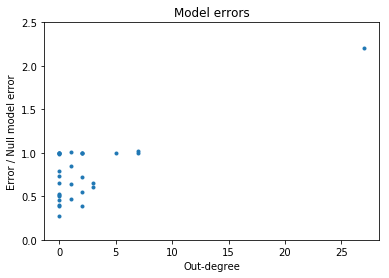

In [99]:
plt.plot(out_degrees, mad_errors / null_errors, '.')
plt.xlabel("Out-degree")
plt.ylabel("Error / Null model error")
plt.title("Model errors")
plt.ylim(0, 2.5)
plt.show()

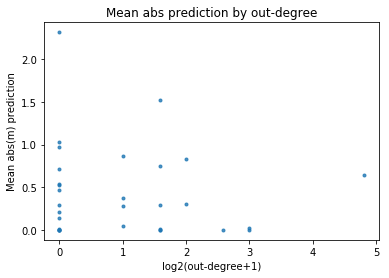

In [113]:
plt.plot(np.log2(np.array(out_degrees) + 1), np.mean(np.abs(y_pred), axis=0), '.', alpha=0.8)
plt.xlabel("log2(out-degree+1)")
plt.ylabel("Mean abs(m) prediction")
plt.title("Mean abs prediction by out-degree")
#plt.xlim(0, 25)
plt.show()

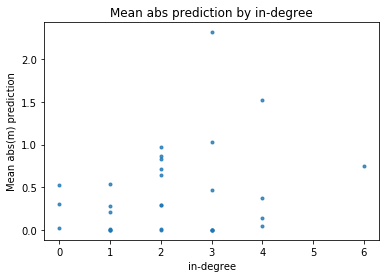

In [112]:
plt.plot(in_degrees, np.mean(np.abs(y_pred), axis=0), '.', alpha=0.8)
plt.xlabel("in-degree")
plt.ylabel("Mean abs(m) prediction")
plt.title("Mean abs prediction by in-degree")
#plt.xlim(0, 25)
plt.show()

In [51]:
np.sum(mad_errors) / np.sum(null_errors)

0.66613881016647425

In [52]:
len(nodes1)

31

In [56]:
Aa_sn, Ai_sn = nx.adjacency_matrix(sn_act), nx.adjacency_matrix(sn_inh)
Aa_sn, Ai_sn = Aa_sn.toarray().transpose(), Ai_sn.toarray().transpose()

In [57]:
import pickle
fit_params_full = pickle.load(open('fit_params_full.p', 'rb'))

times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])

# You can change this if you want higher resolution for the model timepoints. 
# I kind of find it better to just look at the same timepoints to more easily
# compare with data in this plot.
ts = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
y_pred = get_predictions_f3(fit_params_full.x, hss_indices, Aa_sn, Ai_sn, times=ts, n_hss=5)

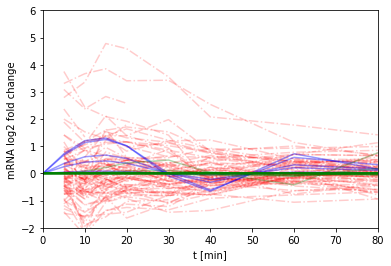

In [58]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-.', color="red", alpha=0.2)
plt.plot(ts, y_pred[:, hss_indices], '-', color="blue", alpha=0.4)
plt.plot(ts, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '-', color='green', alpha=0.3)
plt.xlabel('t [min]')
plt.ylabel('mRNA log2 fold change')
plt.xlim(0, 80)
plt.ylim(-2, 6)
plt.show()

In [82]:
len(nodes)

86

In [8]:
heat_shock_starters

['HSF1', 'MSN2', 'MSN4', 'RLM1', 'SWI4']